# MODERN PORTFOLIO THEORY & CAPITAL ASSET PRICING MODEL

## 0) Set-up

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import random


In [2]:
from library.main import Portfolio

In [3]:
portfolio = Portfolio()

In [4]:
sp500 =portfolio.extract_tickers()
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [5]:
# Get the first 100 tickers
list_of_tickers = random.sample(sp500["Symbol"].tolist(), 15)
list_of_tickers

['AAPL',
 'SPG',
 'WAB',
 'AXON',
 'ED',
 'ALL',
 'MET',
 'MPWR',
 'LIN',
 'IEX',
 'AVB',
 'EIX',
 'PNC',
 'TEL',
 'MKTX']

In [6]:
start_date = "2000-01-01"
end_date = "2019-12-31"

In [7]:
portfolio.update_tickers(list_of_tickers, start_date, end_date)

=> Downloading data for WAB from 2000-01-01 to 2019-12-31
=> Downloading data for AAPL from 2000-01-01 to 2019-12-31
=> Downloading data for SPG from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for AXON from 2000-01-01 to 2019-12-31
=> Downloading data for ED from 2000-01-01 to 2019-12-31
=> Downloading data for ALL from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for MET from 2000-01-01 to 2019-12-31
=> Downloading data for MPWR from 2000-01-01 to 2019-12-31
=> Downloading data for LIN from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for IEX from 2000-01-01 to 2019-12-31
=> Downloading data for AVB from 2000-01-01 to 2019-12-31
=> Downloading data for EIX from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for PNC from 2000-01-01 to 2019-12-31
=> Downloading data for TEL from 2000-01-01 to 2019-12-31
=> Downloading data for MKTX from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(info['metrics'].loc["mean"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:198: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  std = float(info['metrics'].loc["std"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min = float(info['metrics'].loc["min"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:200: FutureWarning: Calling floa

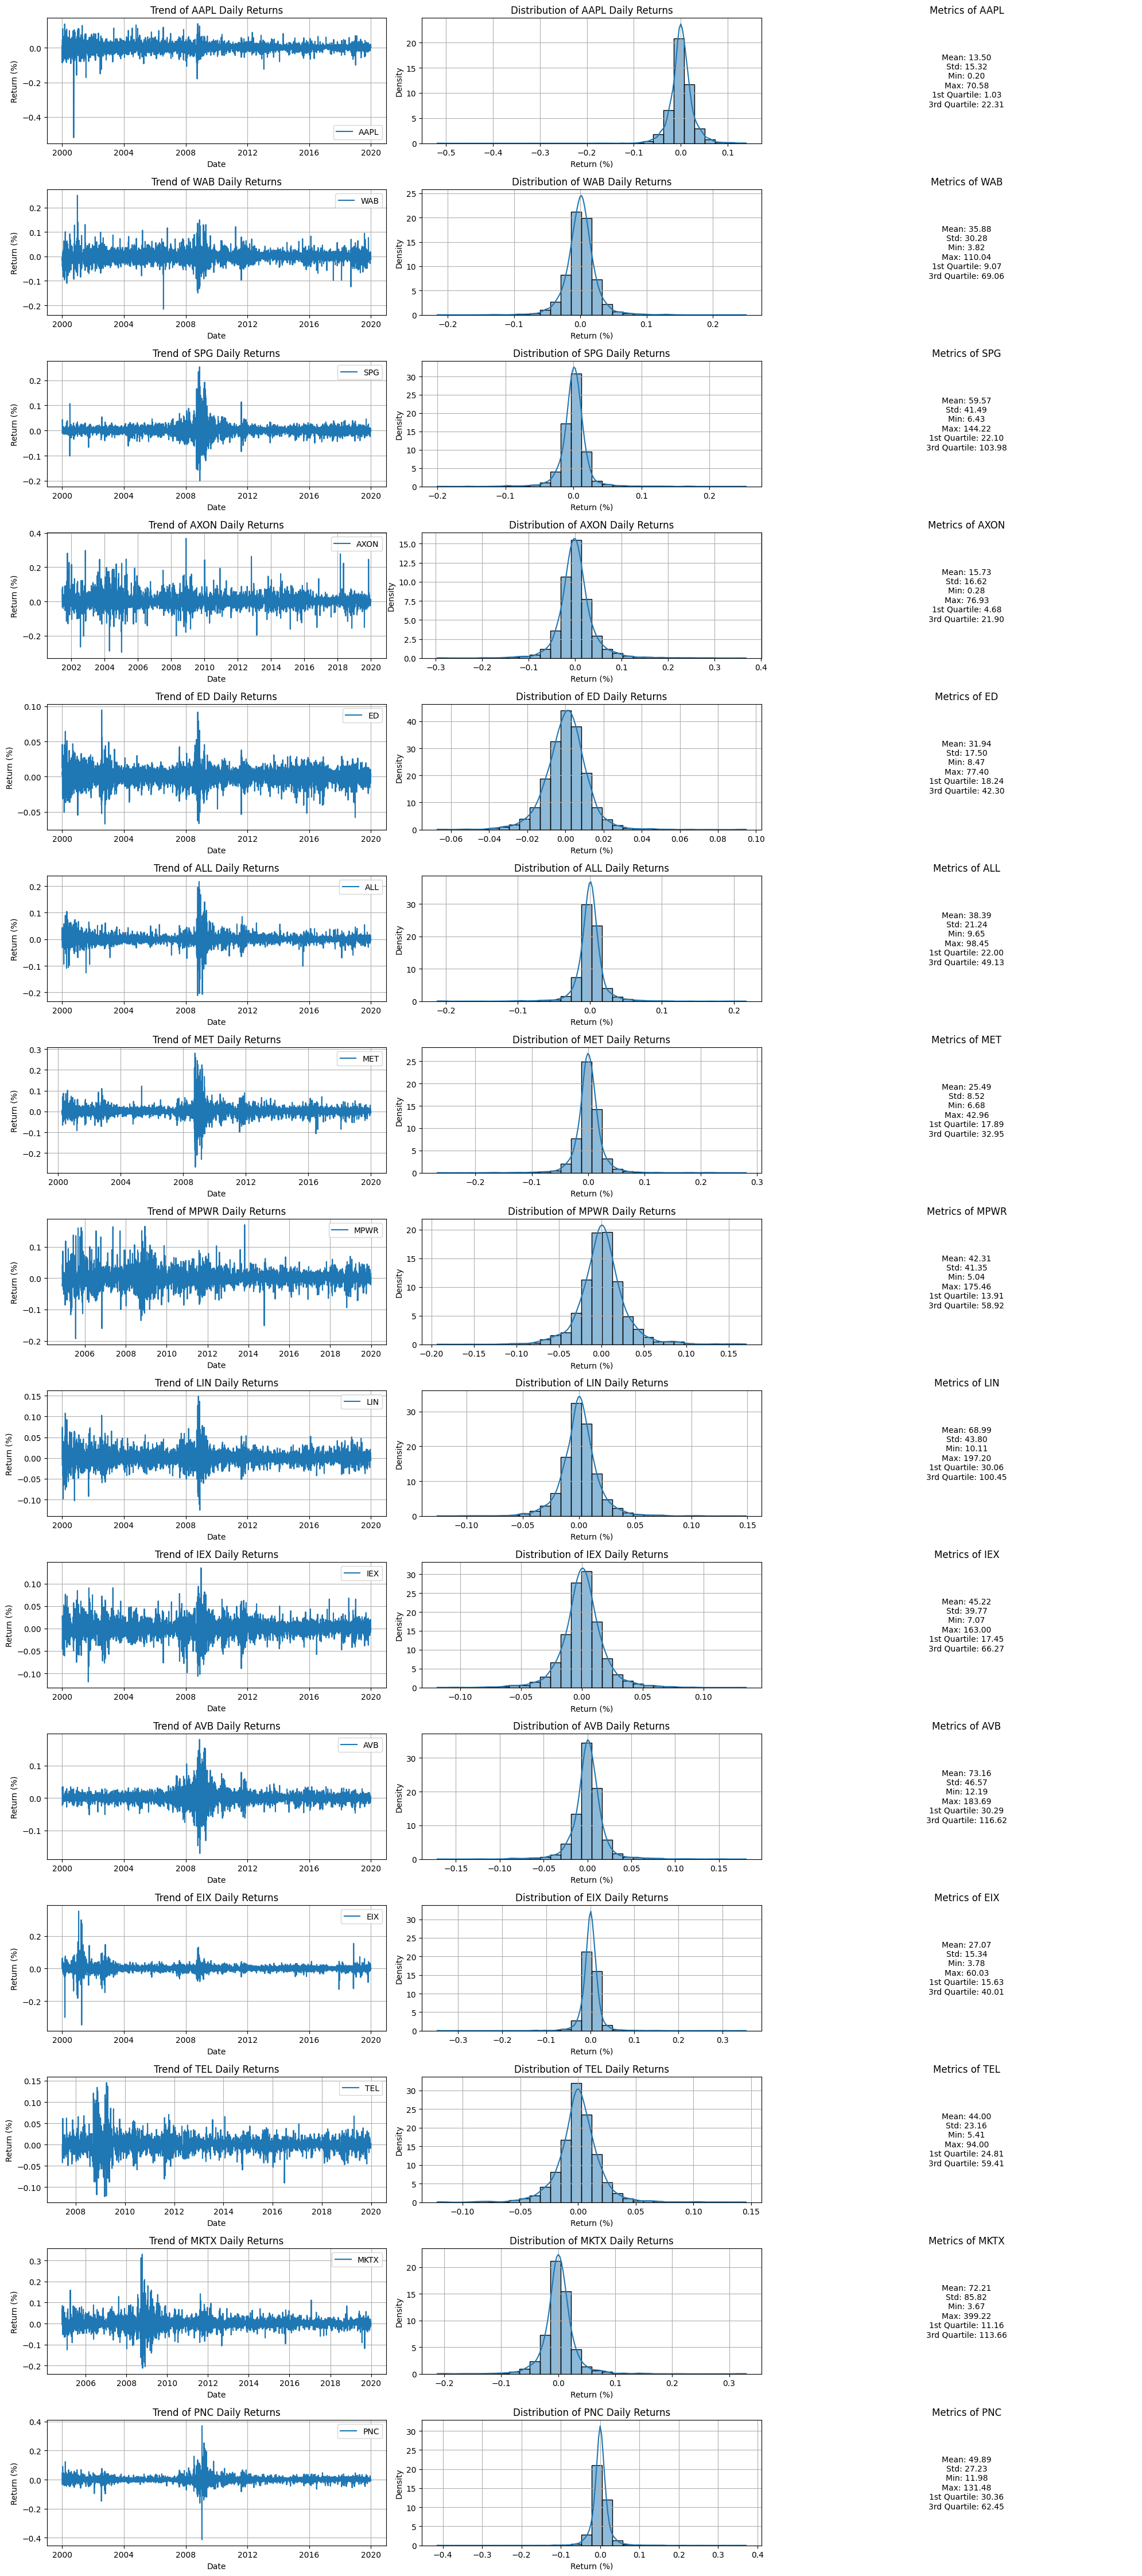

In [8]:
portfolio.analyze_securities()

Now lets observe the expected returns if we were to invest solely in a single asset

In [9]:
portfolio.data_extractor.analayze_single_security_returns()

Security: AAPL
Mean expected return: 0.0012188983136984083
Risk: 0.025393895526115186


Security: WAB
Mean expected return: 0.0007148158514642294
Risk: 0.023088673025474286


Security: SPG
Mean expected return: 0.0007788212370746609
Risk: 0.020934824224086837


Security: AXON
Mean expected return: 0.0018610180497767716
Risk: 0.03958294998054747


Security: ED
Mean expected return: 0.00044944667753176614
Risk: 0.01135186894465084


Security: ALL
Mean expected return: 0.0005921832878283033
Risk: 0.0192253093025095


Security: MET
Mean expected return: 0.0006648171091031525
Risk: 0.02545944362747108


Security: MPWR
Mean expected return: 0.0011735042200376829
Risk: 0.027711990934467703


Security: LIN
Mean expected return: 0.000646098839889113
Risk: 0.017028283917303294


Security: IEX
Mean expected return: 0.0007295847339246009
Risk: 0.01784464536094263


Security: AVB
Mean expected return: 0.0007001554688091054
Risk: 0.018831149869784406


Security: EIX
Mean expected return: 0.000559806

In [10]:
len(list(portfolio.securities.keys()))

15

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


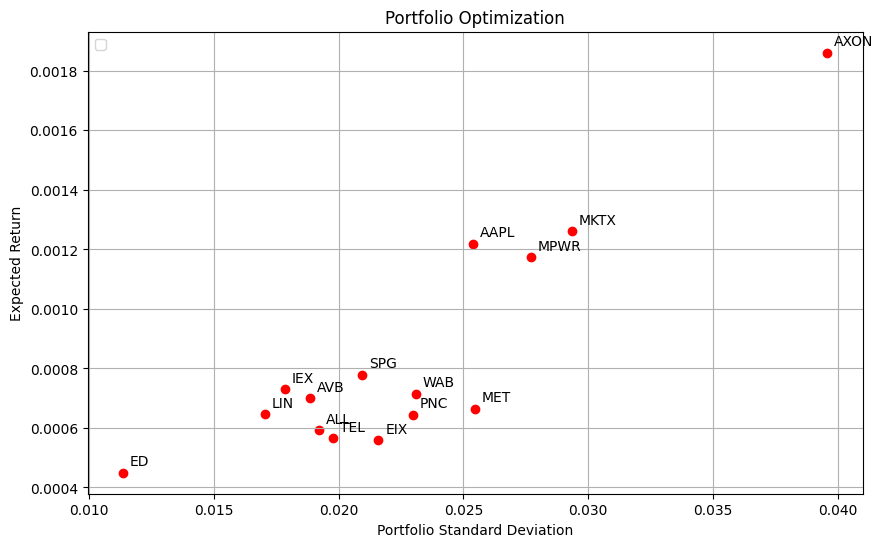

In [11]:
portfolio.plots.plot_results(include_individual_securities=True)

As you will be able to observe in our library, the way we extract returns is by levearing yfinance's dataframe column 'Adj close'. It stands for adjusted close (price) and it account for the splits and dividends over time. We then compute the percentage change over time of this returns (current value and prior). Note these measures are taken on a daily basis. If you are interested into reading more about this way of computing the returns, you can [read yahoo's blog](https://help.yahoo.com/kb/SLN28256.html#:~:text=What%20is%20the%20adjusted%20close%3F).

In accordance with the CER (cosntant expected return) model -- returns follow a i.i.d normal distribution we need to check the fitting of such distribution and alert of possible violations of this assumption.

<hr>

## 1) Extracting matrices 

In [12]:
portfolio.data_extractor.compute_matrices()

In [13]:
portfolio.data_extractor.SIGMA

array([[6.44978182e-04, 1.66619998e-04, 1.43680605e-04, 1.84516623e-04,
        3.68267171e-05, 1.22101210e-04, 1.85957860e-04, 1.99562496e-04,
        1.29424223e-04, 1.54016613e-04, 1.19625158e-04, 8.13205325e-05,
        1.81093459e-04, 1.85457641e-04, 1.61466577e-04],
       [1.66619998e-04, 5.33192846e-04, 2.08366513e-04, 2.26282941e-04,
        5.72335167e-05, 1.62140031e-04, 2.38247675e-04, 2.24882651e-04,
        1.61331735e-04, 2.07860822e-04, 1.81857613e-04, 1.00361616e-04,
        2.37301278e-04, 2.62241925e-04, 1.99451241e-04],
       [1.43680605e-04, 2.08366513e-04, 4.38354031e-04, 2.26320332e-04,
        8.02308038e-05, 2.02501150e-04, 2.76582820e-04, 2.07764636e-04,
        1.51406489e-04, 1.65326801e-04, 3.26077930e-04, 1.21620444e-04,
        2.38075230e-04, 3.08744884e-04, 2.72713202e-04],
       [1.84516623e-04, 2.26282941e-04, 2.26320332e-04, 1.56714615e-03,
        4.93801083e-05, 1.83092994e-04, 2.68052643e-04, 2.66757655e-04,
        1.58460493e-04, 1.91588816e-0

In [14]:
portfolio.data_extractor.SIGMA_INV

array([[ 1.89538242e+03, -1.11267542e+02, -7.43353516e+01,
        -4.97385937e+01,  1.22892112e+02, -2.05251548e+00,
        -3.20425218e+00, -1.82561091e+02, -2.14709213e+02,
        -2.85999598e+02,  1.34497556e+02, -7.13983848e+01,
        -2.93844053e+02, -8.84685836e+01, -1.24825366e+02],
       [-1.11267542e+02,  2.95181455e+03, -2.49766143e+02,
        -6.92468847e+01,  1.67606521e+01, -1.19162135e+01,
        -1.50413513e+01, -1.80985458e+02, -2.91013085e+02,
        -7.82227080e+02, -6.46414489e+01, -3.01402200e+01,
        -6.17038089e+02, -2.38571979e+02, -4.54540172e+01],
       [-7.43353516e+01, -2.49766143e+02,  8.07905519e+03,
        -4.71674018e+01, -9.98459625e+01, -1.62895112e+02,
        -1.23082685e+02, -1.60021936e+02, -1.51210820e+02,
         1.90403139e+02, -5.90322331e+03, -9.51669216e+01,
        -5.88953486e+02, -2.39697635e+02, -7.98201542e+02],
       [-4.97385937e+01, -6.92468847e+01, -4.71674018e+01,
         7.37179851e+02,  9.20448416e+01, -5.19822961

In [15]:
portfolio.data_extractor.MU

array([[0.0012189 ],
       [0.00071482],
       [0.00077882],
       [0.00186102],
       [0.00044945],
       [0.00059218],
       [0.00066482],
       [0.0011735 ],
       [0.0006461 ],
       [0.00072958],
       [0.00070016],
       [0.00055981],
       [0.00056549],
       [0.00126155],
       [0.00064479]])

In [16]:
portfolio.data_extractor.ONE_VECTOR

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

We want to smooth out noise, thus we can cleverly apply PCA to the Sigma matrix. This will significanlty improve the robustness of our model. This is accomplished by making the model less sensitive to estimation errors in the original sigma

In [17]:
portfolio.data_extractor.pca_shrinkage(var_threshold=0.90)

(array([[6.44291593e-04, 1.64670742e-04, 1.42100305e-04, 1.84544854e-04,
         3.75160736e-05, 1.19832881e-04, 1.83441589e-04, 1.99479117e-04,
         1.32208999e-04, 1.57575069e-04, 1.19255612e-04, 8.08826662e-05,
         1.81919815e-04, 1.85571715e-04, 1.65076015e-04],
        [1.64670742e-04, 5.27627985e-04, 2.05102666e-04, 2.26342983e-04,
         5.75104314e-05, 1.54631445e-04, 2.32036691e-04, 2.24428644e-04,
         1.68069799e-04, 2.18060766e-04, 1.80032845e-04, 9.97497629e-05,
         2.40603405e-04, 2.62647303e-04, 2.09031274e-04],
        [1.42100305e-04, 2.05102666e-04, 4.63589341e-04, 2.26492223e-04,
         8.05348855e-05, 2.04342739e-04, 2.69795777e-04, 2.07821023e-04,
         1.55539941e-04, 1.72456947e-04, 2.93033023e-04, 1.21362506e-04,
         2.37941317e-04, 3.09805653e-04, 2.77870454e-04],
        [1.84544854e-04, 2.26342983e-04, 2.26492223e-04, 1.56714998e-03,
         4.98109608e-05, 1.83019952e-04, 2.68206919e-04, 2.66750933e-04,
         1.58221337e-04

In [18]:
# Lets update the class with the new computed data
portfolio.update_data()

# 2) Global Minimum Variance Portfolio
A baseline for our modelling in the risk-return space

In [19]:
results_dict = portfolio.compute_global_minimum_variance_portfolio()

In [20]:
results_dict["weights"], results_dict["weights"].sum()

(array([[ 0.06363318],
        [ 0.01576761],
        [-0.0349801 ],
        [ 0.00821462],
        [ 0.4995714 ],
        [ 0.12747377],
        [-0.11897118],
        [ 0.03391015],
        [ 0.18639177],
        [ 0.1297718 ],
        [ 0.0644605 ],
        [ 0.03178949],
        [-0.04065552],
        [-0.0294354 ],
        [ 0.0630579 ]]),
 np.float64(0.9999999999999999))

In [21]:
results_dict["expected_return"], results_dict["expected_variance"]

(0.0005961652446868253, 0.00011199857410319053)

# 3) Efficient Portfolios
Note we do not restrict to long positions on the securities. We allow for shorting

In [22]:
df = portfolio.compute_efficient_frontier()
df

,weights,variance,sigma,expected_return
0,"[[0.01441995451852178], [0.026005235990984144]...",0.000120,0.010955,0.000449
1,"[[0.01920255851892254], [0.02501033078087253],...",0.000119,0.010888,0.000464
2,"[[0.02398516251932334], [0.024015425570760862]...",0.000117,0.010826,0.000478
3,"[[0.02876776651972421], [0.023020520360649138]...",0.000116,0.010772,0.000492
4,"[[0.03355037052012497], [0.022025615150537442]...",0.000115,0.010724,0.000506
...,...,...,...,...
95,"[[0.46876733455659775], [-0.06851075896962616]...",0.000656,0.025607,0.001804
96,"[[0.4735499385569988], [-0.06950566417973789],...",0.000669,0.025858,0.001818
97,"[[0.4783325425573996], [-0.07050056938984954],...",0.000682,0.026110,0.001833
98,"[[0.4831151465578004], [-0.07149547459996124],...",0.000695,0.026362,0.001847


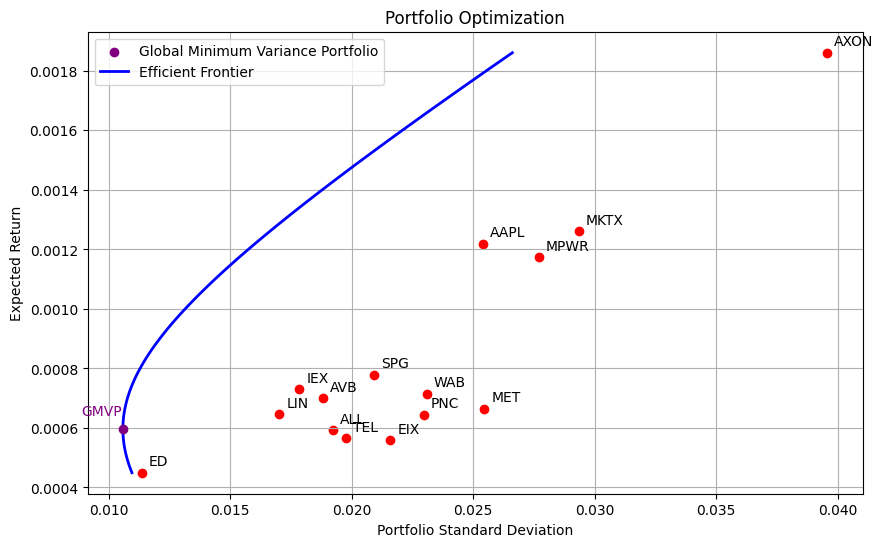

In [23]:
portfolio.plots.plot_results(include_gmvp=True, include_efficient_frontier=True, include_individual_securities=True)

# 4) Capital Asset Pricing Model

In [24]:
annual_risk_free_rate = 0.02
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1 # Formula (assuming 252 days of trading)
daily_risk_free_rate

7.85849419846496e-05

In [25]:
results_dict = portfolio.compute_sharpe_portfolio(daily_risk_free_rate)

In [26]:
results_dict["weights"]

array([[ 0.25836702],
       [-0.02474206],
       [ 0.02793912],
       [ 0.17409719],
       [ 0.28169575],
       [ 0.05735191],
       [-0.13436894],
       [ 0.18454555],
       [ 0.14429261],
       [ 0.1181669 ],
       [ 0.01211746],
       [ 0.02984364],
       [-0.29239335],
       [ 0.16453896],
       [-0.00145176]])

In [27]:
results_dict["expected_return"]

0.001176721951273881

In [28]:
results_dict["expected_variance"]

0.00023762453588019615

In [29]:
print(f'Daily Sharpe ratio: {results_dict["sharpe_ratio"]} \nAnnualized Sharpe ratio: {results_dict["sharpe_ratio"] * np.sqrt(252)}')

Daily Sharpe ratio: 0.07123786374489738 
Annualized Sharpe ratio: 1.1308660284030174


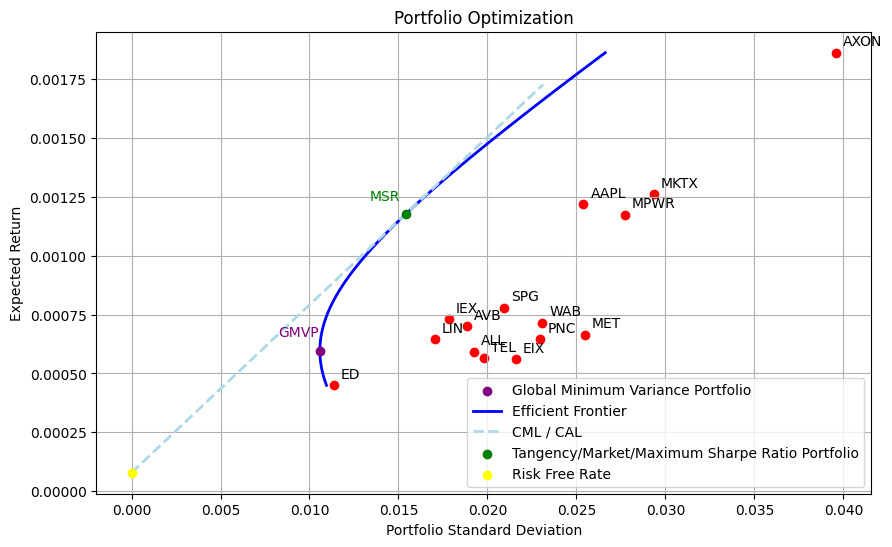

In [30]:
portfolio.plots.plot_results(include_gmvp=True, include_efficient_frontier=True, include_sharpe=True, include_individual_securities=True)